# 4. Model Interpretation & Biological Validation

## 🎯 Purpose

This notebook provides **deep interpretation** of the trained gRNA classifier, validating that the model learns biologically meaningful patterns rather than spurious artifacts.

---

## 📋 Analysis Pipeline

| Stage | Analysis | Question Answered |
|-------|----------|------------------|
| 1 | Load Model & Data | Is everything connected correctly? |
| 2 | Feature Importance Deep Dive | What does the model actually use? |
| 3 | Biological Validation | Do top features match Cooper et al. 2022? |
| 4 | SHAP Analysis | How do features interact? |
| 5 | Error Analysis | What confuses the model? |
| 6 | Confidence Calibration | Are probabilities reliable? |
| 7 | Biological Edge Cases | Does it handle non-canonical correctly? |
| 8 | Final Report | Summary & recommendations |

---

## 🔬 Expected Biological Signals (Cooper et al. 2022)

Based on the paper, a **good** gRNA classifier should prioritize:

| Region | Feature | Expected Behavior | Why |
|--------|---------|-------------------|-----|
| **Anchor** | AC-content | HIGH importance | Prevents GU wobble base-pairing |
| **Anchor** | G-depletion | HIGH importance | Same reason - stabilizes mRNA binding |
| **Initiation** | AWAHH pattern | HIGH importance | 95% of canonical gRNA start this way |
| **Structure** | No palindromes | HIGH importance | gRNA must be open for mRNA binding |
| **Guiding** | A-elevated (>40%) | MEDIUM importance | Encodes editing information |
| **Terminal** | Ends with T | MEDIUM importance | U-tail addition site |
| **Molecular ruler** | Init+anchor=15-19nt | MEDIUM importance | Conserved constraint |

### ⚠️ Red Flags (what should NOT be important)

- **Raw sequence length** → artifact learning
- **Random k-mers without biological meaning** → overfitting
- **Position features without anchor context** → spurious correlation

---

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import warnings
import json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
import joblib

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not available. Install: pip install shap")

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

# Custom color palette for biological regions
REGION_COLORS = {
    'Initiation': '#3498db',  # Blue
    'Anchor': '#e74c3c',      # Red  
    'Guiding': '#2ecc71',     # Green
    'Terminal': '#9b59b6',    # Purple
    'Structure': '#f39c12',   # Orange
    'Composition': '#95a5a6', # Gray
    'Other': '#7f8c8d'        # Dark gray
}

print("✓ Imports loaded")
print(f"  SHAP available: {SHAP_AVAILABLE}")

✓ Imports loaded
  SHAP available: True


In [2]:
# =============================================================================
# FILE PATHS
# =============================================================================

PROJECT_ROOT = Path.home() / 'projects' / 'grna-inspector'
DATA_DIR = PROJECT_ROOT / 'data' / 'processed' / 'v3_pipeline'
MODELS_DIR = PROJECT_ROOT / 'models'
PLOTS_DIR = PROJECT_ROOT / 'data' / 'plots' / 'interpretation_v3'

PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data: {DATA_DIR}")
print(f"Models: {MODELS_DIR}")
print(f"Plots: {PLOTS_DIR}")

Data: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline
Models: /Users/anna/projects/grna-inspector/models
Plots: /Users/anna/projects/grna-inspector/data/plots/interpretation_v3


---
## Stage 1: Load Model & Data

**Checkpoint:** Verify all components are loaded correctly before analysis.

In [3]:
print("="*80)
print("STAGE 1: LOAD MODEL & DATA")
print("="*80)

# Load test data
test_df = pd.read_csv(DATA_DIR / 'test_data.csv')
train_df = pd.read_csv(DATA_DIR / 'train_data.csv')

# Load feature names
with open(DATA_DIR / 'feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

# Load model
model_files = list(MODELS_DIR.glob('grna_classifier_*.joblib'))
if model_files:
    model = joblib.load(model_files[0])
    model_name = model_files[0].stem.replace('grna_classifier_', '').replace('_', ' ').title()
    print(f"\n✓ Model loaded: {model_name}")
else:
    raise FileNotFoundError("No model file found!")

# Load metadata if available
metadata_file = MODELS_DIR / 'model_metadata.json'
if metadata_file.exists():
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    print(f"✓ Metadata loaded")
else:
    metadata = {}

# Prepare data
X_test = test_df[feature_names].values
y_test = test_df['label'].values
X_train = train_df[feature_names].values
y_train = train_df['label'].values

# Get predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"\n📊 Data summary:")
print(f"  Test samples: {len(test_df):,}")
print(f"  Features: {len(feature_names)}")
print(f"  Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"  Test ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

print("\n" + "="*80)

STAGE 1: LOAD MODEL & DATA

✓ Model loaded: Xgboost
✓ Metadata loaded

📊 Data summary:
  Test samples: 348
  Features: 127
  Test accuracy: 0.9483
  Test ROC-AUC: 0.9888



In [4]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def get_feature_region(feature_name):
    """
    Categorize feature by biological region.
    
    Returns one of: Initiation, Anchor, Guiding, Terminal, Structure, Composition, Other
    """
    name = feature_name.lower()
    
    if any(x in name for x in ['init_', 'first_a', 'first_g', 'awahh', 'atata', 'aaaa', 'gaaa', 'agaa']):
        return 'Initiation'
    elif any(x in name for x in ['anchor_', 'molecular_ruler', 'init_anchor']):
        return 'Anchor'
    elif any(x in name for x in ['guide_', 'guiding']):
        return 'Guiding'
    elif any(x in name for x in ['terminal', 'ends_', 'last3', 'last5', 'poly_t', 'utail']):
        return 'Terminal'
    elif any(x in name for x in ['palindrome', 'entropy', 'complexity', 'homopolymer', 'structure']):
        return 'Structure'
    elif any(x in name for x in ['global_', 'kmer', 'dinuc', 'composition']):
        return 'Composition'
    else:
        return 'Other'


def get_expected_importance(feature_name):
    """
    Return expected importance based on Cooper et al. 2022.
    
    Returns: 'HIGH', 'MEDIUM', 'LOW', or 'UNKNOWN'
    """
    high_features = [
        'anchor_ac_content', 'anchor_ac_rich', 'anchor_ac_very_rich',
        'anchor_g_freq', 'anchor_g_depleted',
        'init_any_known_pattern', 'init_starts_a', 'init_has_awahh',
        'no_palindrome_5bp', 'has_palindrome_5bp'
    ]
    medium_features = [
        'guide_a_elevated', 'guide_a_freq',
        'ends_with_t', 'ends_single_t',
        'in_molecular_ruler_range', 'init_anchor_total_len',
        'grna_signature_count'
    ]
    
    name = feature_name.lower()
    if any(f in name for f in high_features):
        return 'HIGH'
    elif any(f in name for f in medium_features):
        return 'MEDIUM'
    else:
        return 'LOW'


print("✓ Helper functions defined")

✓ Helper functions defined


---
## Stage 2: Feature Importance Deep Dive

**Goal:** Understand what the model actually relies on.

**Methods:**
1. **MDI (Mean Decrease Impurity)** - built-in for tree models
2. **Permutation Importance** - model-agnostic, measures actual impact

### ⚠️ Important Note on Interpretation

MDI importance can be biased toward high-cardinality features. Permutation importance is more reliable but computationally expensive. We use both and compare.

In [5]:
print("="*80)
print("STAGE 2: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get MDI importance (if tree-based model)
if hasattr(model, 'feature_importances_'):
    mdi_importance = model.feature_importances_
    print("\n[1/2] MDI (Mean Decrease Impurity) importance extracted")
else:
    mdi_importance = None
    print("\n[1/2] MDI not available for this model type")

# Calculate permutation importance
print("[2/2] Calculating permutation importance (this may take a minute)...")
perm_result = permutation_importance(
    model, X_test, y_test, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)
perm_importance = perm_result.importances_mean
perm_std = perm_result.importances_std
print("✓ Permutation importance calculated")

# Create importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mdi': mdi_importance if mdi_importance is not None else np.zeros(len(feature_names)),
    'permutation': perm_importance,
    'perm_std': perm_std
})

# Add biological annotations
importance_df['region'] = importance_df['feature'].apply(get_feature_region)
importance_df['expected'] = importance_df['feature'].apply(get_expected_importance)

# Sort by permutation importance (more reliable)
importance_df = importance_df.sort_values('permutation', ascending=False).reset_index(drop=True)
importance_df['rank'] = importance_df.index + 1

print("\n" + "="*80)

STAGE 2: FEATURE IMPORTANCE ANALYSIS

[1/2] MDI (Mean Decrease Impurity) importance extracted
[2/2] Calculating permutation importance (this may take a minute)...
✓ Permutation importance calculated



In [6]:
print("="*80)
print("TOP 30 FEATURES (by Permutation Importance)")
print("="*80)

print("\n" + "-"*90)
print(f"{'Rank':<6} {'Feature':<40} {'Perm Imp':>10} {'Region':<12} {'Expected':<8}")
print("-"*90)

for i, row in importance_df.head(30).iterrows():
    # Mark if matches expected
    match = "✓" if row['expected'] in ['HIGH', 'MEDIUM'] else ""
    print(f"{row['rank']:<6} {row['feature']:<40} {row['permutation']:>10.4f} {row['region']:<12} {row['expected']:<8} {match}")

print("-"*90)

# Summary by region
print("\n📊 Feature importance by biological region:")
region_importance = importance_df.groupby('region')['permutation'].agg(['sum', 'mean', 'count'])
region_importance = region_importance.sort_values('sum', ascending=False)
print(region_importance.round(4).to_string())

print("\n" + "="*80)

TOP 30 FEATURES (by Permutation Importance)

------------------------------------------------------------------------------------------
Rank   Feature                                    Perm Imp Region       Expected
------------------------------------------------------------------------------------------
1      dinuc_TT_freq                                0.0193 Composition  LOW      
2      max_homopolymer                              0.0101 Structure    LOW      
3      first_G_pos_rel                              0.0086 Initiation   LOW      
4      n_homopolymers_3plus                         0.0072 Structure    LOW      
5      dinuc_TA_freq                                0.0069 Composition  LOW      
6      dinuc_CA_freq                                0.0063 Composition  LOW      
7      complexity_ratio                             0.0055 Structure    LOW      
8      anchor_C_freq                                0.0055 Anchor       LOW      
9      guide_C_freq                 

---
## Stage 3: Biological Validation

**Key Question:** Does the model learn the right biology?

We compare our model's feature importance against expected importance from Cooper et al. 2022.

In [7]:
print("="*80)
print("STAGE 3: BIOLOGICAL VALIDATION")
print("="*80)

# Define key biological features with expected behavior
biology_check = [
    # (feature, expected_importance, biological_reason)
    ('anchor_AC_content', 'HIGH', 'AC-rich anchor prevents GU wobble, stabilizes mRNA binding'),
    ('anchor_AC_very_rich', 'HIGH', 'Very high AC (>70%) is strong canonical signal'),
    ('anchor_G_freq', 'HIGH', 'G-depletion critical for avoiding GU wobble'),
    ('anchor_G_depleted', 'HIGH', 'Binary indicator of G-depletion'),
    ('init_any_known_pattern', 'HIGH', '95% of canonical gRNA have AWAHH pattern'),
    ('init_starts_A', 'HIGH', '96% start with A (ATA or AAA)'),
    ('init_has_AWAHH', 'HIGH', 'AWAHH consensus in 95% of expressed canonical'),
    ('no_palindrome_5bp', 'HIGH', 'gRNA avoids self-complementarity (80% vs 57%)'),
    ('guide_A_elevated', 'MEDIUM', 'A > 40% in guiding region encodes editing info'),
    ('guide_A_freq', 'MEDIUM', 'A frequency ~40% in guiding region'),
    ('ends_with_T', 'MEDIUM', '90% end with T for U-tail addition'),
    ('ends_single_T', 'MEDIUM', 'Single T (not TT) indicates U-tail readiness'),
    ('in_molecular_ruler_range', 'MEDIUM', 'Init+anchor conserved at 15-19nt'),
    ('grna_signature_count', 'MEDIUM', 'Combined signature score'),
]

print("\n🔬 Biological Feature Validation:")
print("-"*100)
print(f"{'Feature':<35} {'Expected':>10} {'Actual Rank':>12} {'Perm Imp':>10} {'Status':>10}")
print("-"*100)

validated = 0
total = 0

for feature, expected, reason in biology_check:
    # Find feature (case-insensitive)
    matches = importance_df[importance_df['feature'].str.lower() == feature.lower()]
    
    if len(matches) > 0:
        row = matches.iloc[0]
        rank = row['rank']
        perm = row['permutation']
        
        # Validation criteria
        if expected == 'HIGH':
            status = '✓ GOOD' if rank <= 30 else '⚠️ LOW'
            if rank <= 30:
                validated += 1
        else:  # MEDIUM
            status = '✓ GOOD' if rank <= 50 else '⚠️ LOW'
            if rank <= 50:
                validated += 1
        total += 1
        
        print(f"{feature:<35} {expected:>10} {rank:>12} {perm:>10.4f} {status:>10}")
    else:
        print(f"{feature:<35} {expected:>10} {'N/A':>12} {'N/A':>10} {'MISSING':>10}")

print("-"*100)
print(f"\n📊 Validation Score: {validated}/{total} ({validated/total*100:.1f}%)")

if validated/total >= 0.8:
    print("\n✅ EXCELLENT: Model strongly aligns with known gRNA biology!")
elif validated/total >= 0.6:
    print("\n⚠️ ACCEPTABLE: Model partially captures gRNA biology, some features missing.")
else:
    print("\n❌ CONCERNING: Model may be learning spurious patterns!")

print("\n" + "="*80)

STAGE 3: BIOLOGICAL VALIDATION

🔬 Biological Feature Validation:
----------------------------------------------------------------------------------------------------
Feature                               Expected  Actual Rank   Perm Imp     Status
----------------------------------------------------------------------------------------------------
anchor_AC_content                         HIGH           18     0.0023     ✓ GOOD
anchor_AC_very_rich                       HIGH           77     0.0000     ⚠️ LOW
anchor_G_freq                             HIGH           48     0.0003     ⚠️ LOW
anchor_G_depleted                         HIGH           79     0.0000     ⚠️ LOW
init_any_known_pattern                    HIGH           85     0.0000     ⚠️ LOW
init_starts_A                             HIGH           88     0.0000     ⚠️ LOW
init_has_AWAHH                            HIGH           30     0.0014     ✓ GOOD
no_palindrome_5bp                         HIGH           55     0.0000     ⚠️

### 📝 Biological Interpretation Notes

**Instructions:** After running the cell above, update this section with your observations:

#### Anchor Region Analysis
- [ ] Is `anchor_AC_content` in top 10? (Expected: YES)
- [ ] Is `anchor_G_freq` important? (Expected: YES - G depletion is critical)
- **Observation:** _[Fill in: What do you see?]_

#### Initiation Region Analysis  
- [ ] Is `init_starts_A` highly ranked? (96% of gRNA start with A)
- [ ] Are initiation pattern features (AWAHH, AAAA, GAAA) important?
- **Observation:** _[Fill in]_

#### Structure Analysis (NEW in v3)
- [ ] Is `no_palindrome_5bp` highly ranked? (Should be - gRNA avoids hairpins!)
- **Observation:** _[Fill in]_

#### Potential Issues
- [ ] Any unexpected features in top 10? (May indicate artifact learning)
- [ ] Is raw `length` anywhere? (Should NOT be - we excluded it)
- **Observation:** _[Fill in]_

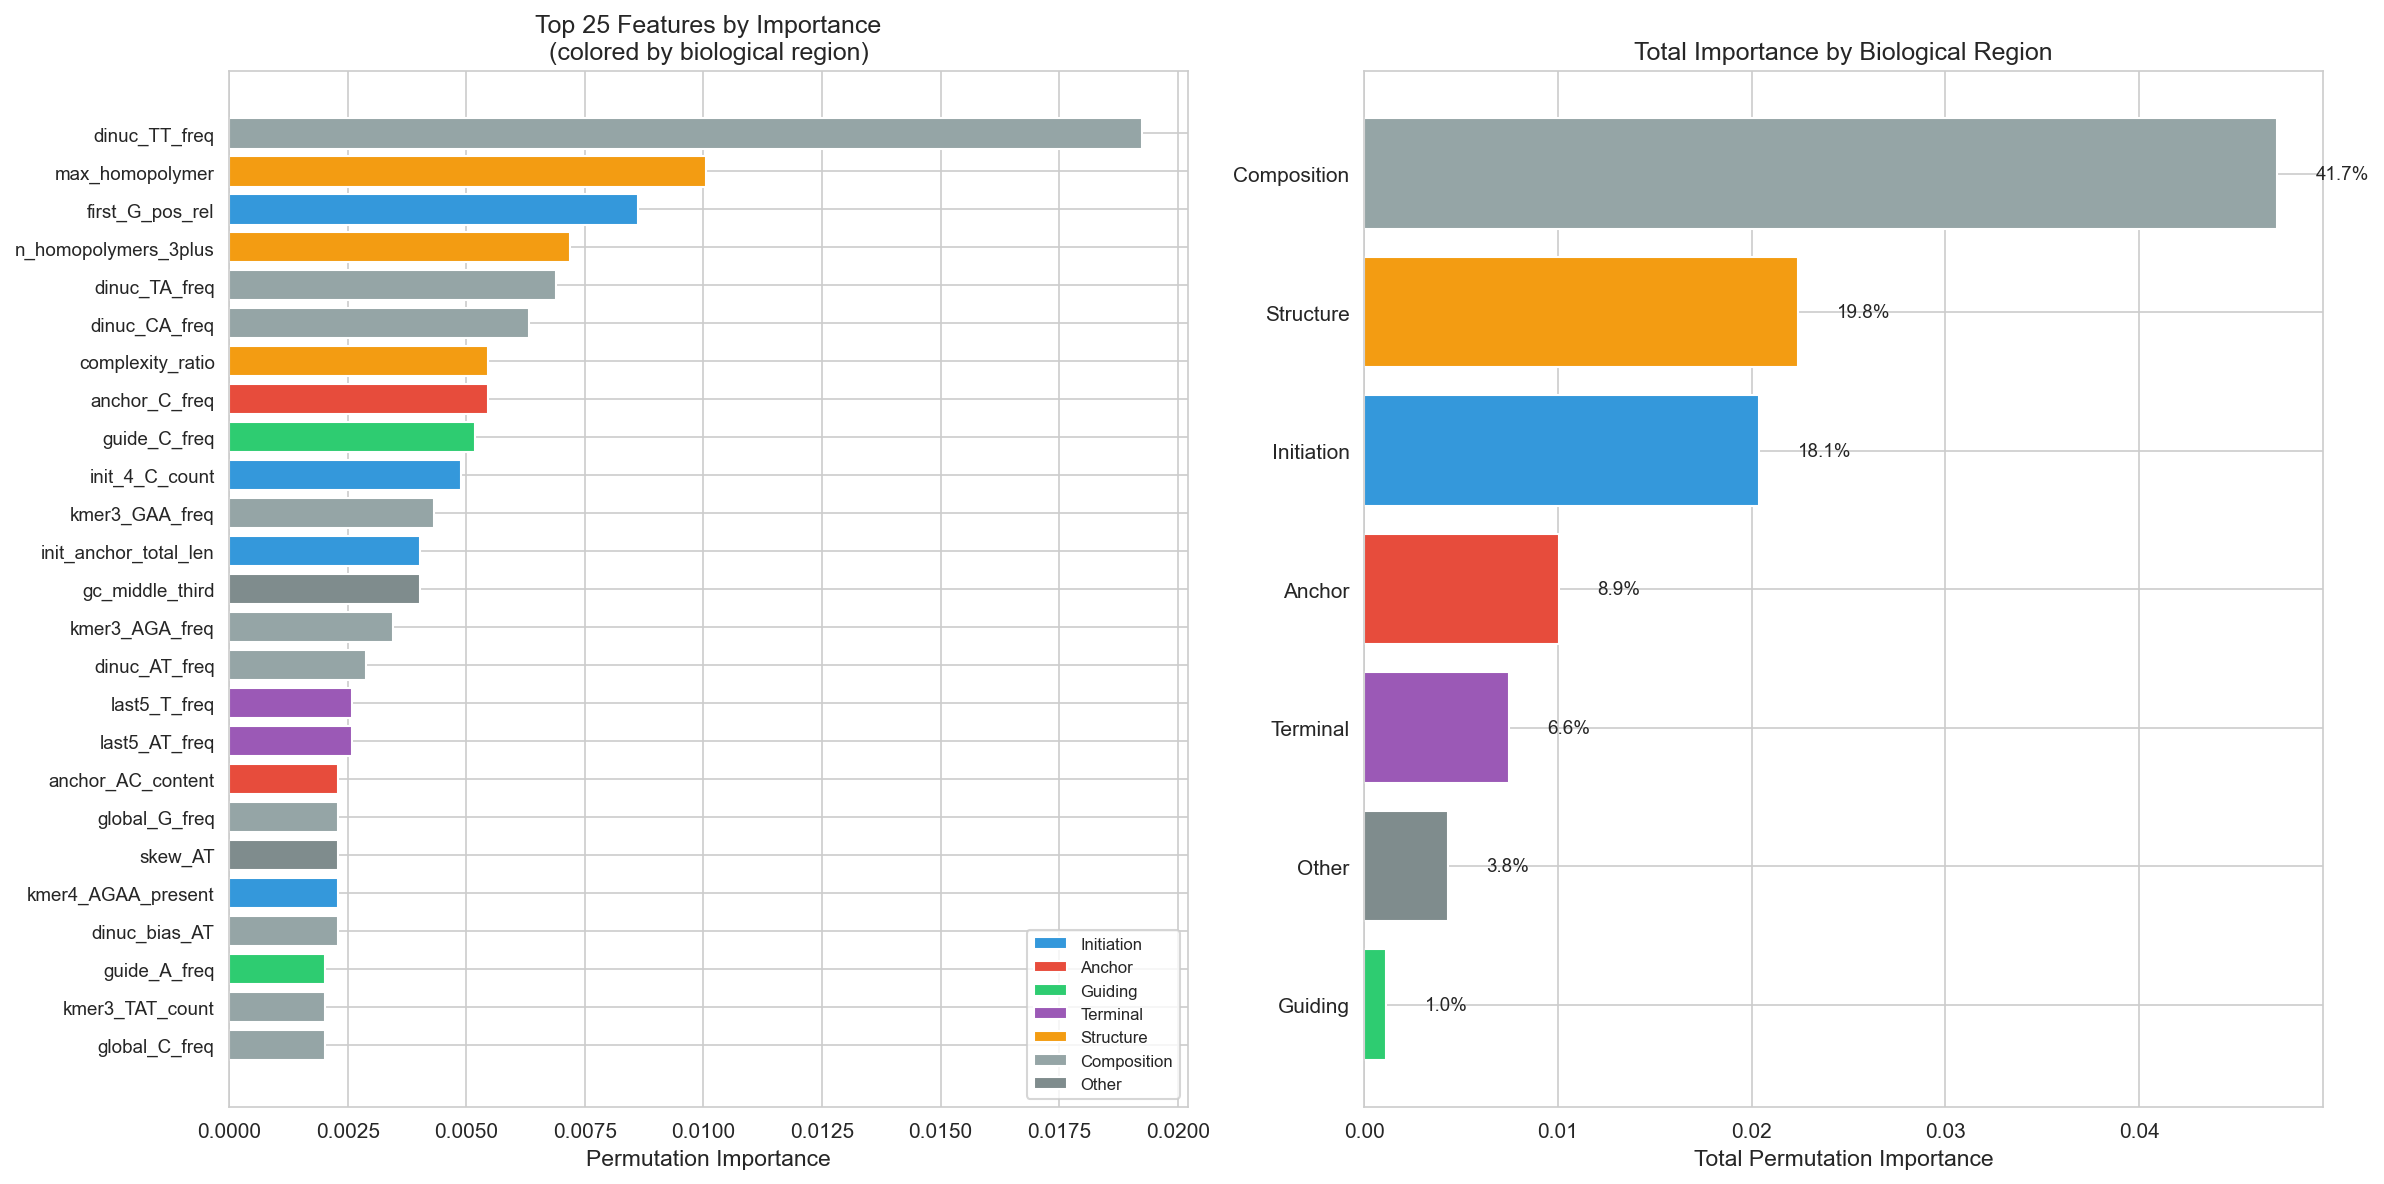


✓ Plot saved: feature_importance_by_region.png


In [8]:
# =============================================================================
# VISUALIZATION: FEATURE IMPORTANCE BY BIOLOGICAL REGION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Top 25 features colored by region
top25 = importance_df.head(25)
colors = [REGION_COLORS.get(r, '#7f8c8d') for r in top25['region']]

bars = axes[0].barh(range(len(top25)), top25['permutation'].values, color=colors)
axes[0].set_yticks(range(len(top25)))
axes[0].set_yticklabels(top25['feature'].values, fontsize=9)
axes[0].invert_yaxis()
axes[0].set_xlabel('Permutation Importance', fontsize=11)
axes[0].set_title('Top 25 Features by Importance\n(colored by biological region)', fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=r) for r, c in REGION_COLORS.items()]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

# Right: Importance by region (pie/bar)
region_sums = importance_df.groupby('region')['permutation'].sum().sort_values(ascending=True)
colors_pie = [REGION_COLORS.get(r, '#7f8c8d') for r in region_sums.index]

axes[1].barh(range(len(region_sums)), region_sums.values, color=colors_pie)
axes[1].set_yticks(range(len(region_sums)))
axes[1].set_yticklabels(region_sums.index)
axes[1].set_xlabel('Total Permutation Importance', fontsize=11)
axes[1].set_title('Total Importance by Biological Region', fontsize=12)

# Add percentage labels
total_imp = region_sums.sum()
for i, (region, val) in enumerate(region_sums.items()):
    pct = val / total_imp * 100
    axes[1].text(val + 0.002, i, f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'feature_importance_by_region.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: feature_importance_by_region.png")

---
## Stage 4: SHAP Analysis (Deep Interpretability)

**SHAP (SHapley Additive exPlanations)** provides:
1. **Feature attribution** for each prediction
2. **Interaction effects** between features
3. **Direction of effect** (positive vs negative contribution)

### Key Questions:
- Do high anchor AC values push toward gRNA prediction? (Expected: YES)
- Do palindromes push toward non-gRNA? (Expected: YES)
- Are there unexpected interactions?

STAGE 4: SHAP ANALYSIS

Creating SHAP explainer (this may take a moment)...
✓ SHAP values computed for 348 samples


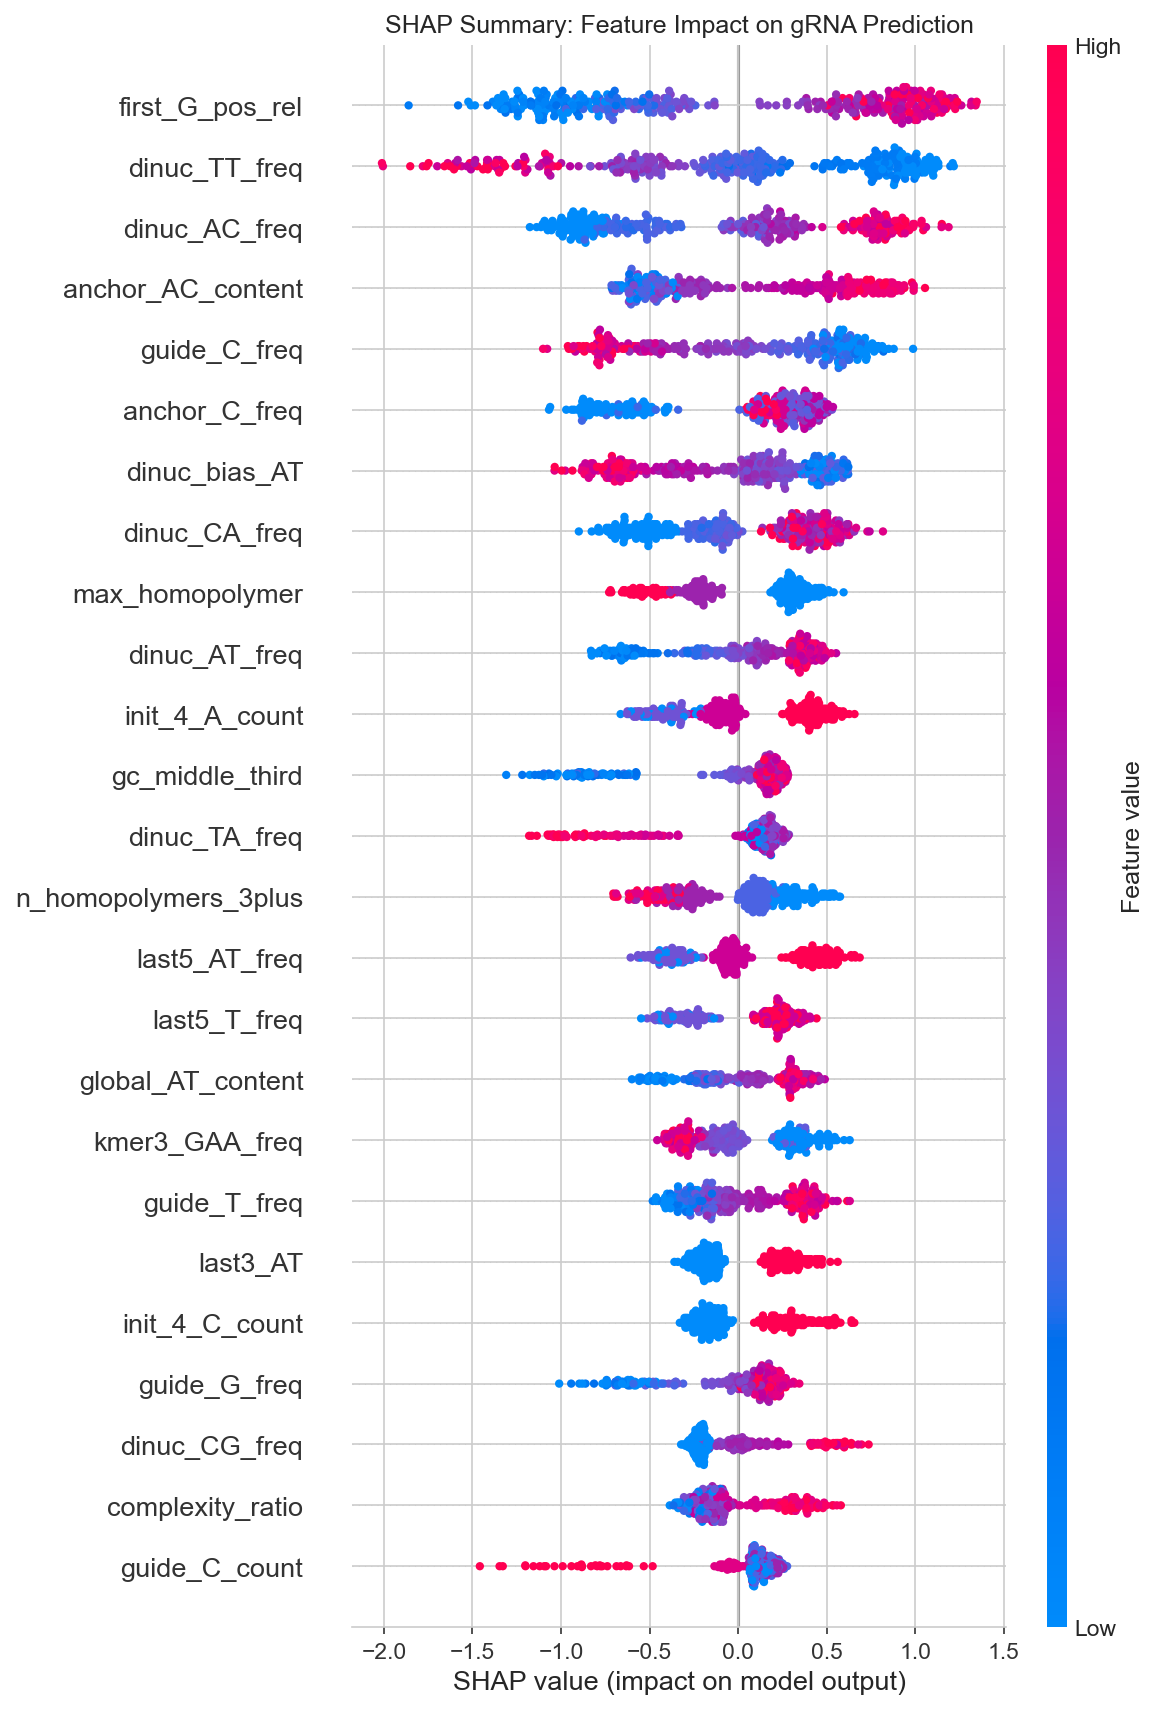

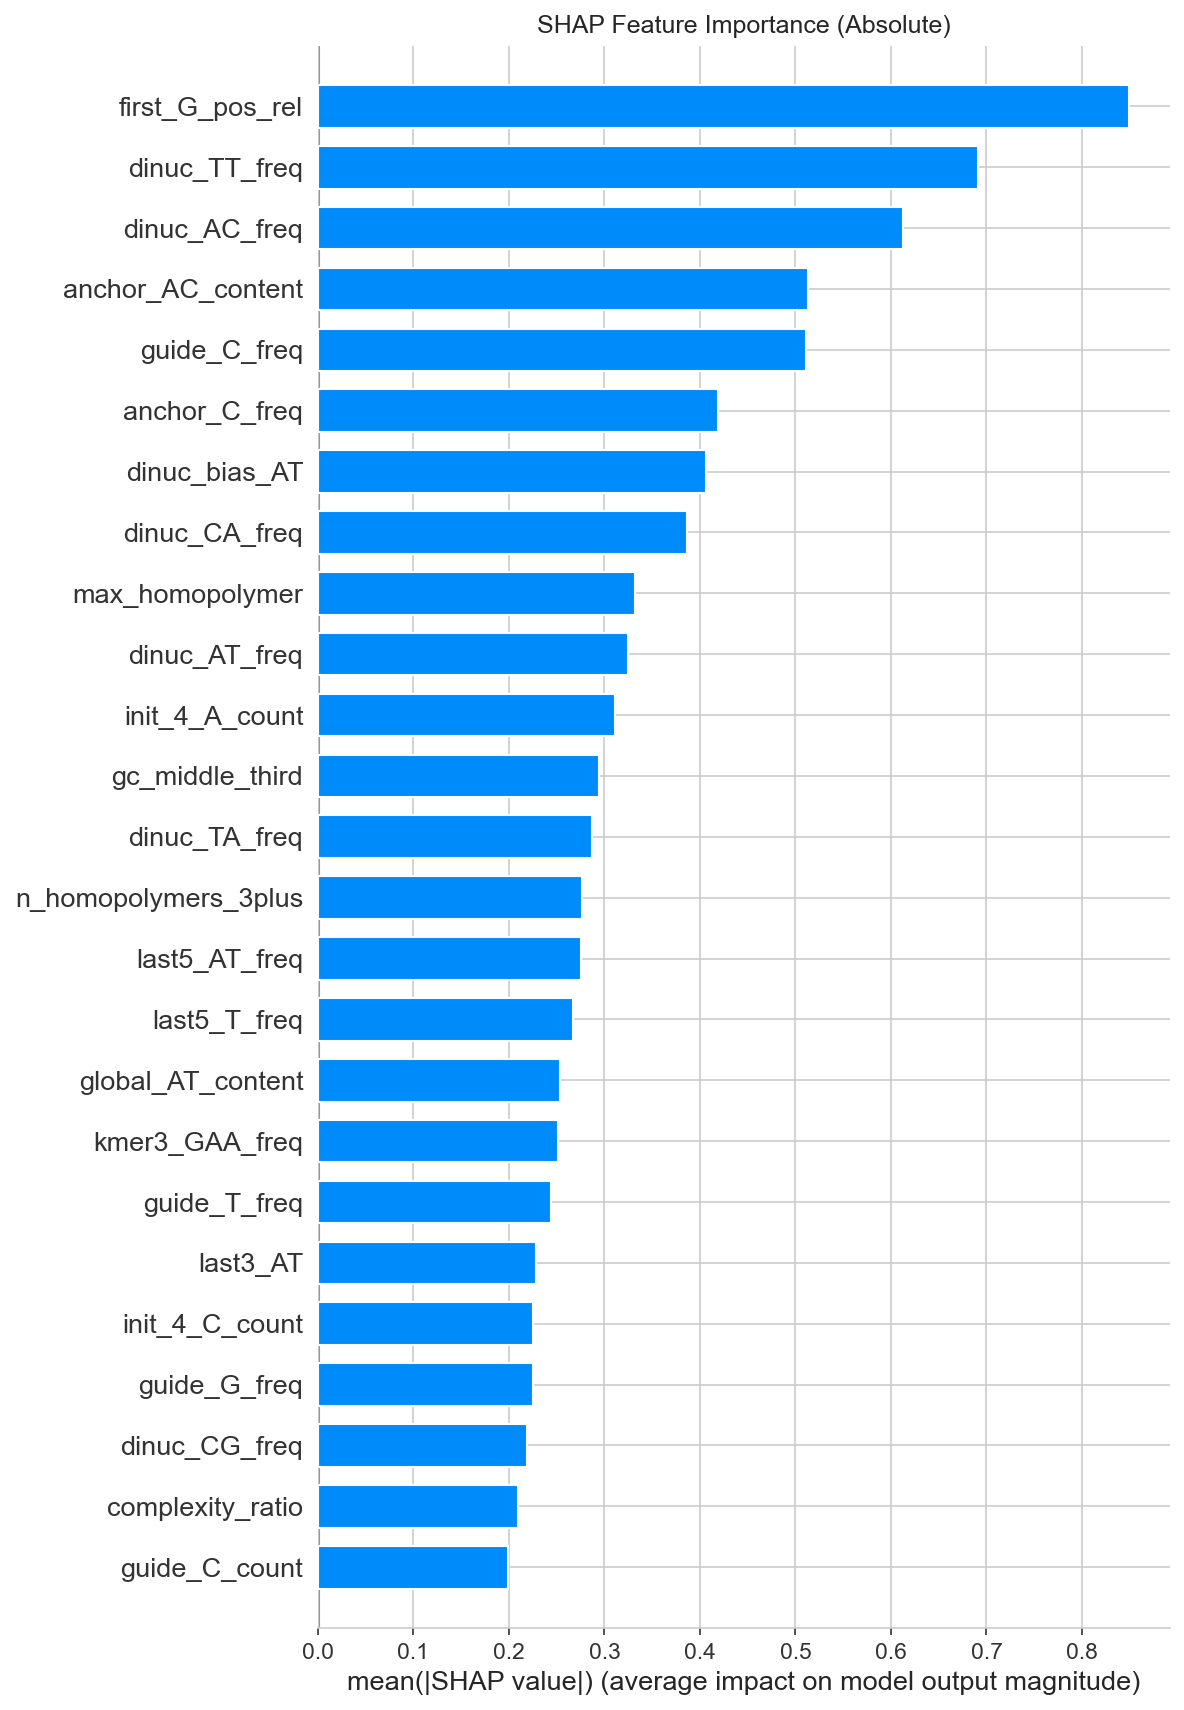


✓ SHAP plots saved


In [9]:
if SHAP_AVAILABLE:
    print("="*80)
    print("STAGE 4: SHAP ANALYSIS")
    print("="*80)
    
    # Create SHAP explainer
    print("\nCreating SHAP explainer (this may take a moment)...")
    explainer = shap.TreeExplainer(model)
    
    # Use subset for visualization
    n_samples = min(500, len(X_test))
    X_shap = X_test[:n_samples]
    
    shap_values = explainer.shap_values(X_shap)
    
    # Handle binary classification
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class
    
    print(f"✓ SHAP values computed for {n_samples} samples")
    
    # Summary plot
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_shap, feature_names=feature_names, 
                     show=False, max_display=25)
    plt.title('SHAP Summary: Feature Impact on gRNA Prediction', fontsize=12)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'shap_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Bar plot (absolute importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_shap, feature_names=feature_names,
                     plot_type='bar', show=False, max_display=25)
    plt.title('SHAP Feature Importance (Absolute)', fontsize=12)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'shap_bar.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ SHAP plots saved")
else:
    print("⚠️ SHAP not available - skipping this analysis.")
    print("   Install with: pip install shap")

### 📝 SHAP Interpretation Notes

**How to read the SHAP summary plot:**
- Each dot is one sample
- **Color** = feature value (red = high, blue = low)
- **Position** = SHAP value (right = pushes toward gRNA, left = away from gRNA)

**Expected patterns for gRNA classifier:**

| Feature | Expected Pattern | Reason |
|---------|-----------------|--------|
| `anchor_AC_content` | Red dots on right | High AC → gRNA |
| `anchor_G_freq` | Red dots on LEFT | High G → NOT gRNA |
| `has_palindrome_5bp` | Red dots on LEFT | Has palindrome → NOT gRNA |
| `init_starts_A` | Red dots on right | Starts with A → gRNA |

**Your observations:**
- _[Fill in what you see in the SHAP plots]_

---
## Stage 5: Error Analysis

**Goal:** Understand what confuses the model.

### Key Questions:
1. Are False Negatives missing biological signals?
2. Are False Positives mimicking gRNA features?
3. Are errors near decision boundary (low confidence) or high-confidence mistakes?

In [10]:
print("="*80)
print("STAGE 5: ERROR ANALYSIS")
print("="*80)

# Create analysis DataFrame
error_df = test_df.copy()
error_df['predicted'] = y_pred
error_df['probability'] = y_prob
error_df['correct'] = (error_df['label'] == error_df['predicted'])

# Classify errors
def classify_error(row):
    if row['correct']:
        return 'Correct'
    elif row['label'] == 1 and row['predicted'] == 0:
        return 'False Negative'
    else:
        return 'False Positive'

error_df['error_type'] = error_df.apply(classify_error, axis=1)

# Summary statistics
print("\n📊 Prediction Summary:")
error_counts = error_df['error_type'].value_counts()
for error_type, count in error_counts.items():
    pct = count / len(error_df) * 100
    print(f"  {error_type}: {count} ({pct:.1f}%)")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"                non-gRNA    gRNA")
print(f"  Actual non-gRNA   {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"  Actual gRNA       {cm[1,0]:4d}      {cm[1,1]:4d}")

print("\n" + "="*80)

STAGE 5: ERROR ANALYSIS

📊 Prediction Summary:
  Correct: 330 (94.8%)
  False Positive: 13 (3.7%)
  False Negative: 5 (1.4%)

📊 Confusion Matrix:
                Predicted
                non-gRNA    gRNA
  Actual non-gRNA    161        13
  Actual gRNA          5       169



In [11]:
# Analyze errors in detail
false_negatives = error_df[error_df['error_type'] == 'False Negative']
false_positives = error_df[error_df['error_type'] == 'False Positive']
correct_grna = error_df[(error_df['error_type'] == 'Correct') & (error_df['label'] == 1)]

print("\n🔍 FALSE NEGATIVES Analysis (gRNA predicted as non-gRNA):")
print("-"*60)

if len(false_negatives) > 0:
    print(f"Count: {len(false_negatives)}")
    print(f"Mean probability: {false_negatives['probability'].mean():.3f}")
    
    # Compare key features
    key_features = ['anchor_AC_content', 'init_any_known_pattern', 'guide_A_freq', 
                   'no_palindrome_5bp', 'ends_with_T']
    
    available_features = [f for f in key_features if f in error_df.columns]
    
    if available_features:
        print(f"\nKey feature comparison (FN vs Correct gRNA):")
        print(f"{'Feature':<30} {'FN Mean':>12} {'Correct Mean':>14} {'Diff':>10}")
        print("-"*68)
        for feat in available_features:
            fn_mean = false_negatives[feat].mean()
            correct_mean = correct_grna[feat].mean()
            diff = fn_mean - correct_mean
            flag = '⚠️' if abs(diff) > 0.1 else ''
            print(f"{feat:<30} {fn_mean:>12.3f} {correct_mean:>14.3f} {diff:>+10.3f} {flag}")
else:
    print("No false negatives! 🎉")

print("\n🔍 FALSE POSITIVES Analysis (non-gRNA predicted as gRNA):")
print("-"*60)

if len(false_positives) > 0:
    print(f"Count: {len(false_positives)}")
    print(f"Mean probability: {false_positives['probability'].mean():.3f}")
    
    # Check source of FP
    if 'source' in error_df.columns:
        print(f"\nFP by source:")
        fp_by_source = false_positives['source'].value_counts()
        for source, count in fp_by_source.items():
            print(f"  {source}: {count}")
else:
    print("No false positives! 🎉")

print("\n" + "="*80)


🔍 FALSE NEGATIVES Analysis (gRNA predicted as non-gRNA):
------------------------------------------------------------
Count: 5
Mean probability: 0.363

Key feature comparison (FN vs Correct gRNA):
Feature                             FN Mean   Correct Mean       Diff
--------------------------------------------------------------------
anchor_AC_content                     0.578          0.781     -0.203 ⚠️
init_any_known_pattern                0.200          0.509     -0.309 ⚠️
guide_A_freq                          0.400          0.408     -0.008 
no_palindrome_5bp                     0.400          0.751     -0.351 ⚠️
ends_with_T                           0.400          0.450     -0.050 

🔍 FALSE POSITIVES Analysis (non-gRNA predicted as gRNA):
------------------------------------------------------------
Count: 13
Mean probability: 0.813

FP by source:
  random: 8
  chimeric: 5



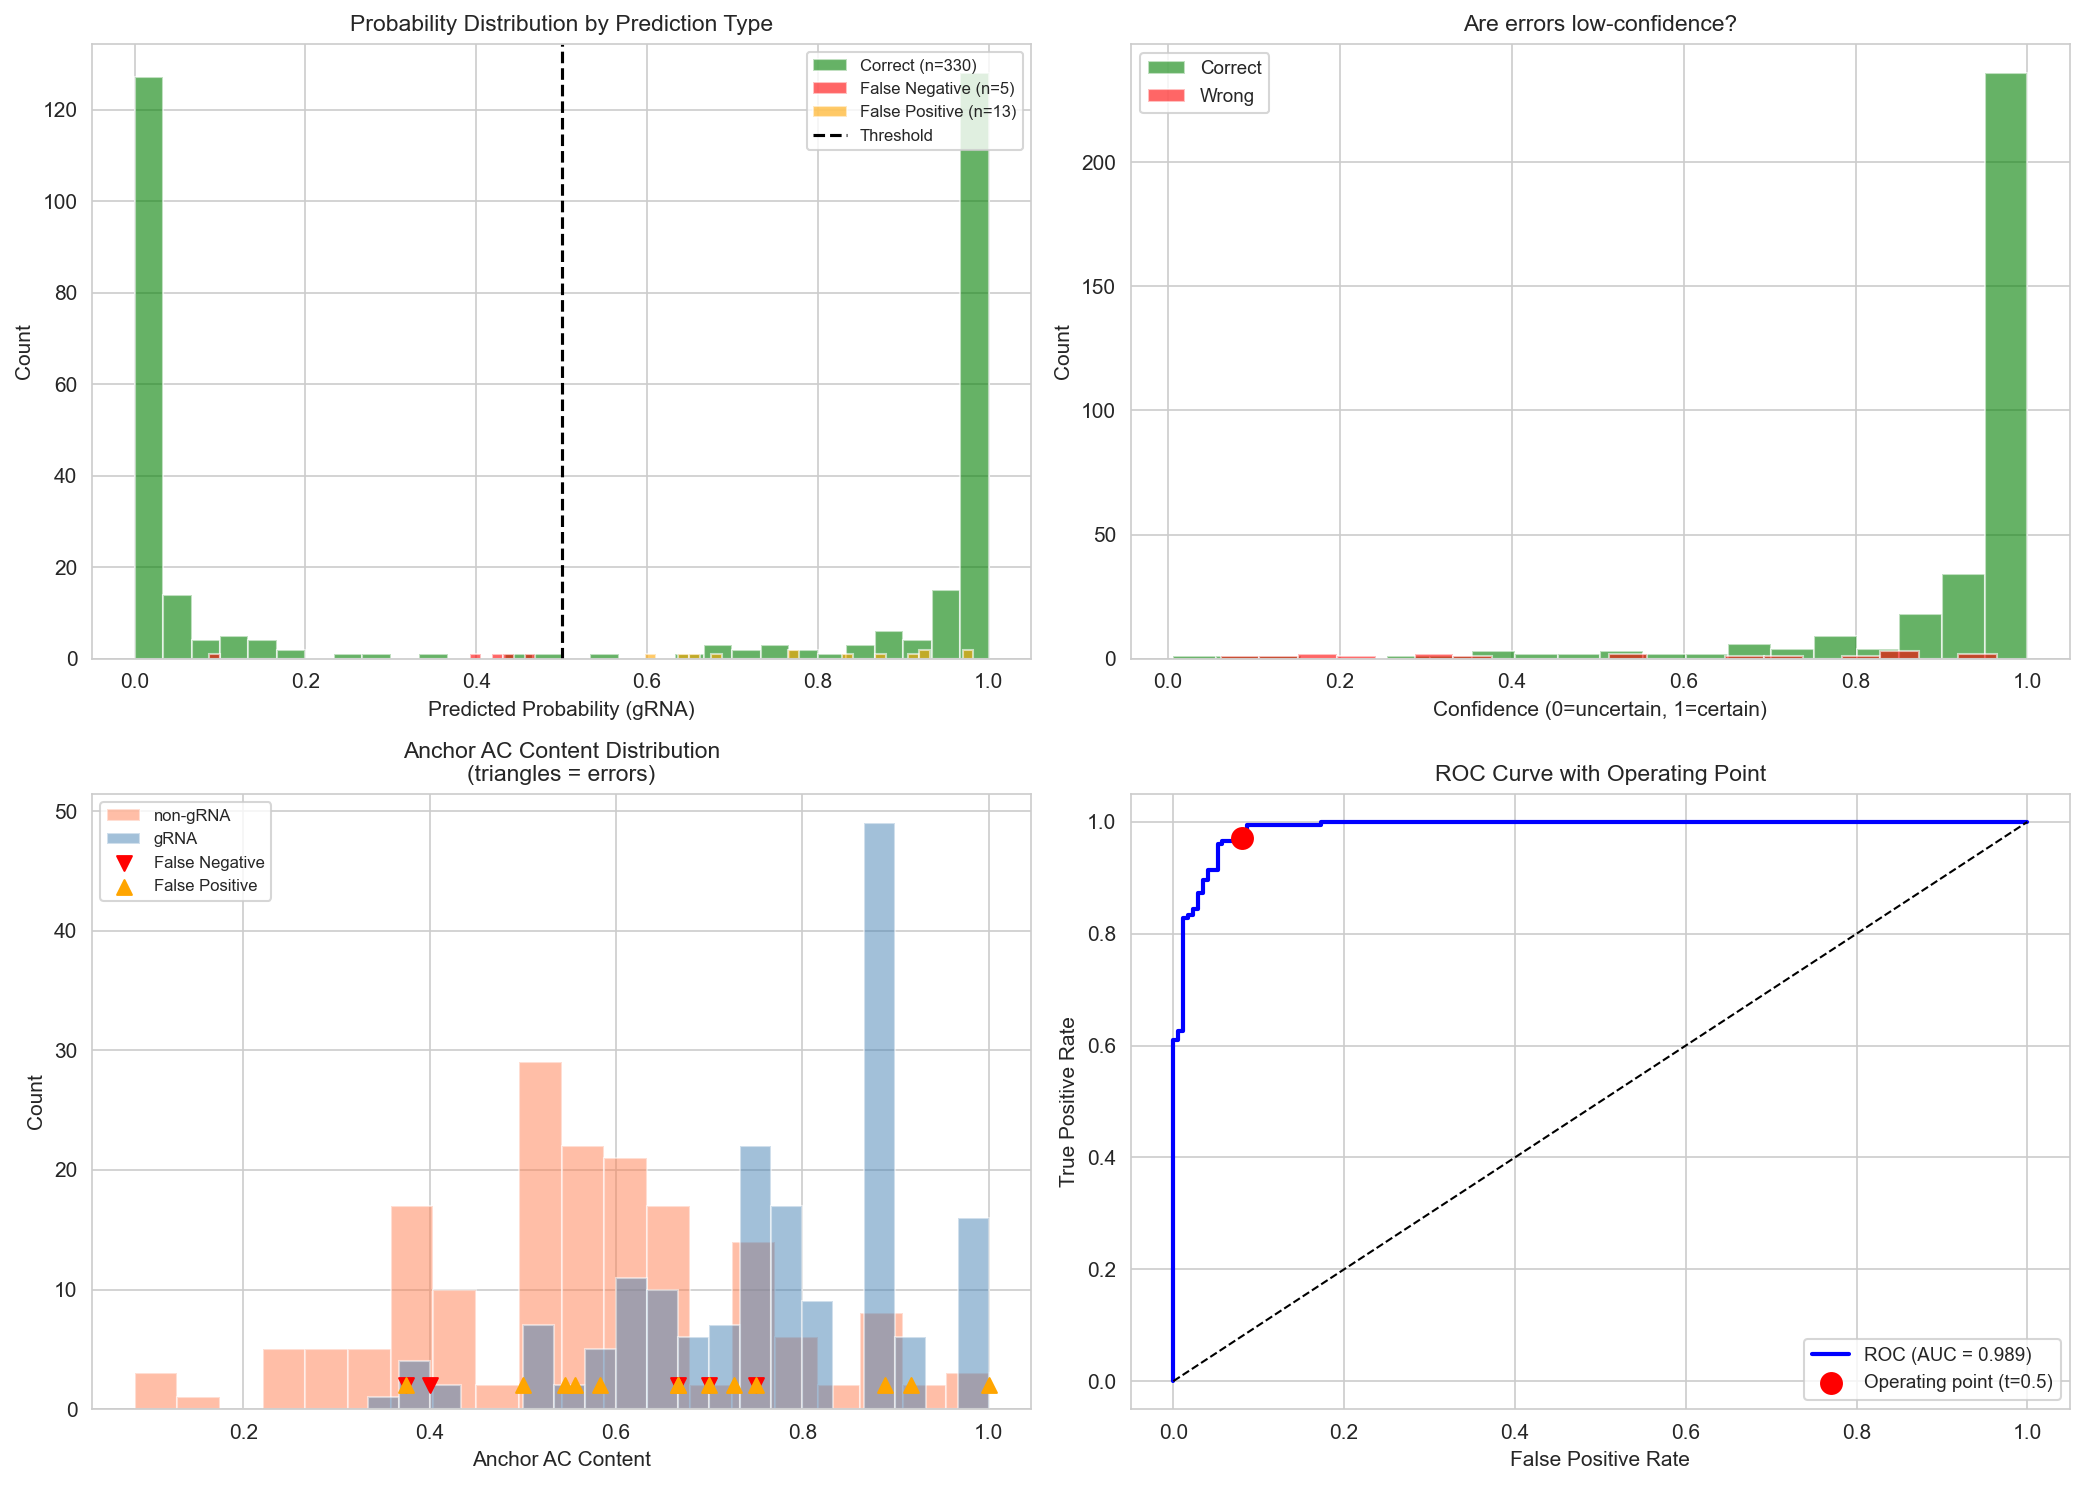


✓ Plot saved: error_analysis.png


In [12]:
# Visualize error patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Probability distribution by error type
for error_type, color in [('Correct', 'green'), ('False Negative', 'red'), ('False Positive', 'orange')]:
    subset = error_df[error_df['error_type'] == error_type]
    if len(subset) > 0:
        axes[0, 0].hist(subset['probability'], bins=30, alpha=0.6, 
                       label=f"{error_type} (n={len(subset)})", color=color)
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[0, 0].set_xlabel('Predicted Probability (gRNA)', fontsize=10)
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Probability Distribution by Prediction Type', fontsize=11)
axes[0, 0].legend(fontsize=8)

# 2. Confidence distribution for errors
error_df['confidence'] = np.abs(error_df['probability'] - 0.5) * 2
correct_conf = error_df[error_df['correct']]['confidence']
wrong_conf = error_df[~error_df['correct']]['confidence']

axes[0, 1].hist(correct_conf, bins=20, alpha=0.6, label='Correct', color='green')
if len(wrong_conf) > 0:
    axes[0, 1].hist(wrong_conf, bins=20, alpha=0.6, label='Wrong', color='red')
axes[0, 1].set_xlabel('Confidence (0=uncertain, 1=certain)', fontsize=10)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Are errors low-confidence?', fontsize=11)
axes[0, 1].legend(fontsize=9)

# 3. Key feature comparison: Anchor AC content
if 'anchor_AC_content' in error_df.columns:
    for label, name, color in [(0, 'non-gRNA', 'coral'), (1, 'gRNA', 'steelblue')]:
        subset = error_df[error_df['label'] == label]
        axes[1, 0].hist(subset['anchor_AC_content'], bins=20, alpha=0.5, label=name, color=color)
    # Mark errors
    for error_type, marker, color in [('False Negative', 'v', 'red'), ('False Positive', '^', 'orange')]:
        subset = error_df[error_df['error_type'] == error_type]
        if len(subset) > 0:
            axes[1, 0].scatter(subset['anchor_AC_content'], np.ones(len(subset)) * 2, 
                              marker=marker, s=50, c=color, label=error_type, zorder=5)
    axes[1, 0].set_xlabel('Anchor AC Content', fontsize=10)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Anchor AC Content Distribution\n(triangles = errors)', fontsize=11)
    axes[1, 0].legend(fontsize=8)

# 4. ROC curve with operating point
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

axes[1, 1].plot(fpr, tpr, 'b-', lw=2, label=f'ROC (AUC = {auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=1)
# Mark operating point (threshold=0.5)
idx = np.argmin(np.abs(thresholds - 0.5))
axes[1, 1].scatter([fpr[idx]], [tpr[idx]], c='red', s=100, zorder=5, label='Operating point (t=0.5)')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=10)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=10)
axes[1, 1].set_title('ROC Curve with Operating Point', fontsize=11)
axes[1, 1].legend(loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: error_analysis.png")

---
## Stage 6: Confidence Calibration

**Goal:** Are the model's probability outputs reliable?

A well-calibrated model should have:
- Samples predicted with 80% confidence → ~80% actually positive
- This matters if we use probabilities for downstream decisions

STAGE 6: CALIBRATION ANALYSIS

📊 Calibration Metrics:
  Expected Calibration Error (ECE): 0.0225
  Interpretation: Well calibrated


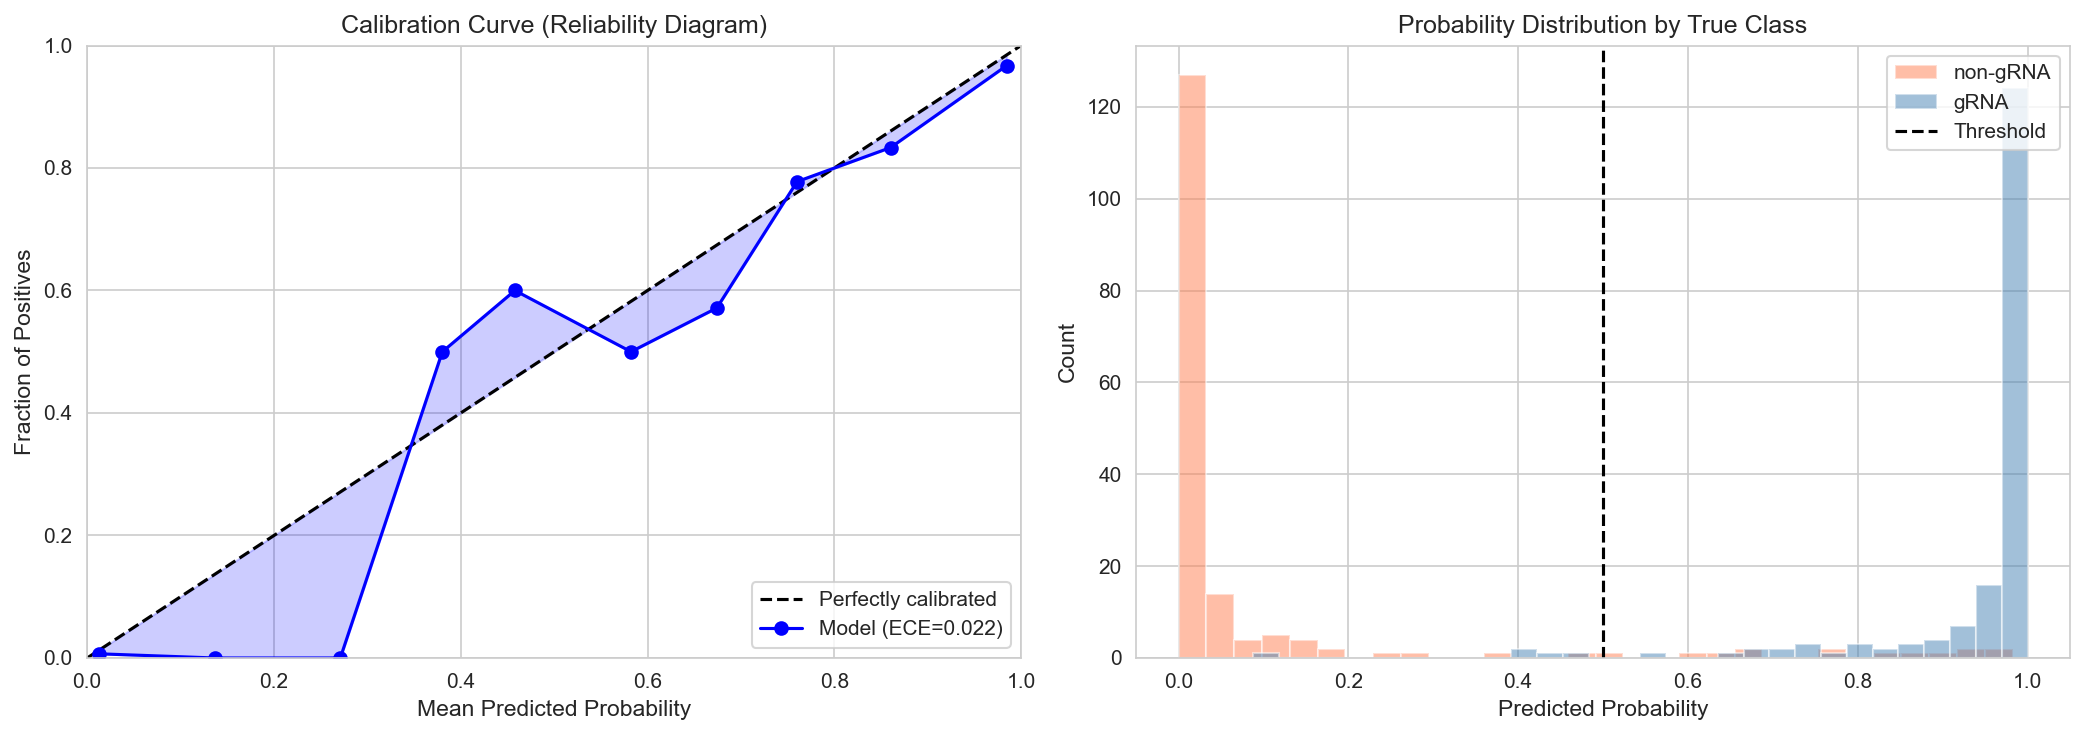


✓ Plot saved: calibration_analysis.png



In [13]:
print("="*80)
print("STAGE 6: CALIBRATION ANALYSIS")
print("="*80)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Calculate Expected Calibration Error (ECE)
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

ece = 0.0
for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (y_prob >= bin_lower) & (y_prob < bin_upper)
    prop_in_bin = in_bin.mean()
    if prop_in_bin > 0:
        avg_confidence = y_prob[in_bin].mean()
        avg_accuracy = y_test[in_bin].mean()
        ece += np.abs(avg_accuracy - avg_confidence) * prop_in_bin

print(f"\n📊 Calibration Metrics:")
print(f"  Expected Calibration Error (ECE): {ece:.4f}")
print(f"  Interpretation: {'Well calibrated' if ece < 0.1 else 'Needs calibration' if ece < 0.2 else 'Poorly calibrated'}")

# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reliability diagram
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[0].plot(prob_pred, prob_true, 'bo-', label=f'Model (ECE={ece:.3f})')
axes[0].fill_between(prob_pred, prob_true, prob_pred, alpha=0.2, color='blue')
axes[0].set_xlabel('Mean Predicted Probability', fontsize=11)
axes[0].set_ylabel('Fraction of Positives', fontsize=11)
axes[0].set_title('Calibration Curve (Reliability Diagram)', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Probability histogram
axes[1].hist(y_prob[y_test == 0], bins=30, alpha=0.5, label='non-gRNA', color='coral')
axes[1].hist(y_prob[y_test == 1], bins=30, alpha=0.5, label='gRNA', color='steelblue')
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1].set_xlabel('Predicted Probability', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Probability Distribution by True Class', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'calibration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: calibration_analysis.png")
print("\n" + "="*80)

---
## Stage 7: Threshold Optimization

**Goal:** Find optimal classification threshold for different use cases.

| Use Case | Priority | Optimal Threshold |
|----------|----------|------------------|
| Discovery (find all gRNA) | High Recall | Lower threshold |
| Annotation (high confidence) | High Precision | Higher threshold |
| Balanced | F1 score | Default 0.5 or optimized |

STAGE 7: THRESHOLD OPTIMIZATION

📊 Optimal Thresholds:
  Best F1 score:     t=0.30 (F1=0.9532)
  High Recall (≥95%): t=0.65
  High Precision (≥95%): t=0.80

📊 Performance at Key Thresholds:
----------------------------------------------------------------------
 Threshold   Accuracy  Precision     Recall         F1
----------------------------------------------------------------------
      0.30     0.9511     0.9153     0.9943     0.9532 ← Best F1
      0.40     0.9511     0.9198     0.9885     0.9529
      0.50     0.9483     0.9286     0.9713     0.9494
      0.30     0.9511     0.9153     0.9943     0.9532 ← Best F1
      0.60     0.9483     0.9333     0.9655     0.9492
      0.70     0.9454     0.9480     0.9425     0.9452


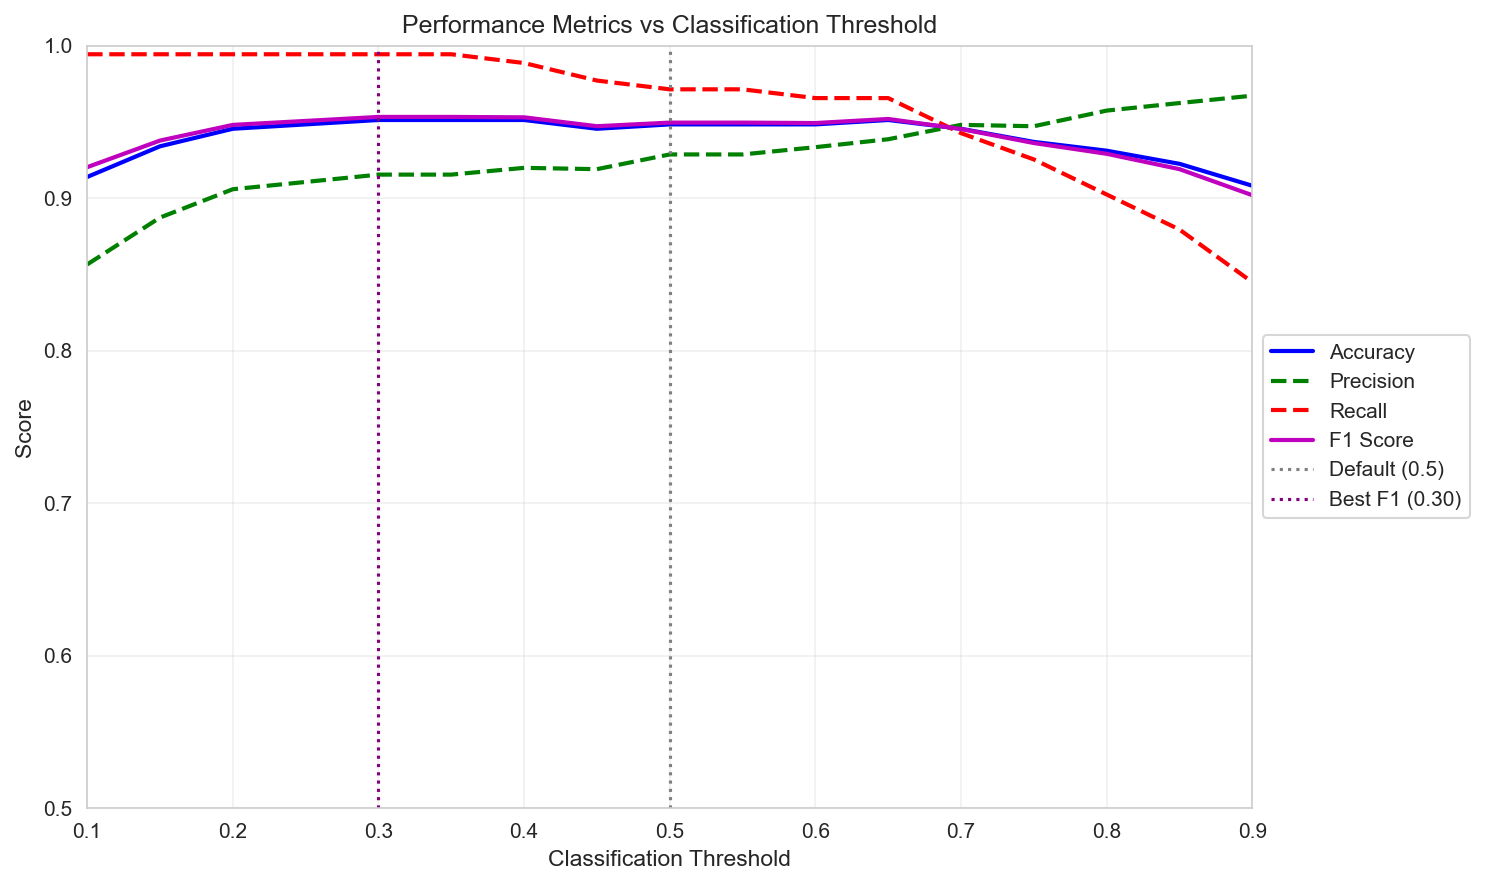


✓ Plot saved: threshold_analysis.png



In [14]:
print("="*80)
print("STAGE 7: THRESHOLD OPTIMIZATION")
print("="*80)

# Test different thresholds
thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred_t = (y_prob >= thresh).astype(int)
    results.append({
        'threshold': thresh,
        'accuracy': accuracy_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t, zero_division=0),
        'recall': recall_score(y_test, y_pred_t, zero_division=0),
        'f1': f1_score(y_test, y_pred_t, zero_division=0)
    })

thresh_df = pd.DataFrame(results)

# Find optimal thresholds
best_f1_idx = thresh_df['f1'].idxmax()
best_f1_thresh = thresh_df.loc[best_f1_idx, 'threshold']

# High recall threshold (recall >= 0.95)
high_recall = thresh_df[thresh_df['recall'] >= 0.95]
if len(high_recall) > 0:
    best_recall_thresh = high_recall['threshold'].max()  # Highest threshold with recall >= 95%
else:
    best_recall_thresh = thresh_df.loc[thresh_df['recall'].idxmax(), 'threshold']

# High precision threshold (precision >= 0.95)
high_prec = thresh_df[thresh_df['precision'] >= 0.95]
if len(high_prec) > 0:
    best_prec_thresh = high_prec['threshold'].min()  # Lowest threshold with precision >= 95%
else:
    best_prec_thresh = thresh_df.loc[thresh_df['precision'].idxmax(), 'threshold']

print(f"\n📊 Optimal Thresholds:")
print(f"  Best F1 score:     t={best_f1_thresh:.2f} (F1={thresh_df.loc[best_f1_idx, 'f1']:.4f})")
print(f"  High Recall (≥95%): t={best_recall_thresh:.2f}")
print(f"  High Precision (≥95%): t={best_prec_thresh:.2f}")

# Performance at each threshold
print(f"\n📊 Performance at Key Thresholds:")
print("-"*70)
print(f"{'Threshold':>10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-"*70)
for t in [0.3, 0.4, 0.5, best_f1_thresh, 0.6, 0.7]:
    row = thresh_df[thresh_df['threshold'].round(2) == round(t, 2)]
    if len(row) > 0:
        r = row.iloc[0]
        mark = ' ← Best F1' if abs(t - best_f1_thresh) < 0.01 else ''
        print(f"{r['threshold']:>10.2f} {r['accuracy']:>10.4f} {r['precision']:>10.4f} {r['recall']:>10.4f} {r['f1']:>10.4f}{mark}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresh_df['threshold'], thresh_df['accuracy'], 'b-', lw=2, label='Accuracy')
ax.plot(thresh_df['threshold'], thresh_df['precision'], 'g--', lw=2, label='Precision')
ax.plot(thresh_df['threshold'], thresh_df['recall'], 'r--', lw=2, label='Recall')
ax.plot(thresh_df['threshold'], thresh_df['f1'], 'm-', lw=2, label='F1 Score')

ax.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax.axvline(x=best_f1_thresh, color='purple', linestyle=':', label=f'Best F1 ({best_f1_thresh:.2f})')

ax.set_xlabel('Classification Threshold', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Performance Metrics vs Classification Threshold', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([0.1, 0.9])
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: threshold_analysis.png")
print("\n" + "="*80)

---
## Stage 8: Final Summary Report

In [15]:
print("\n")
print("#" * 80)
print("#" + " " * 78 + "#")
print("#" + "     FINAL MODEL INTERPRETATION REPORT".center(78) + "#")
print("#" + " " * 78 + "#")
print("#" * 80)

print("\n" + "="*80)
print("1. MODEL PERFORMANCE")
print("="*80)

print(f"\n  Model: {model_name}")
print(f"  Test Samples: {len(y_test):,}")
print(f"\n  Metrics:")
print(f"    Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"    Precision: {precision_score(y_test, y_pred):.4f}")
print(f"    Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"    F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"    ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")

print("\n" + "="*80)
print("2. BIOLOGICAL VALIDATION")
print("="*80)

# Top features by region
print("\n  Top 5 Features by Biological Region:")
for region in ['Anchor', 'Initiation', 'Guiding', 'Structure', 'Terminal']:
    region_feats = importance_df[importance_df['region'] == region].head(2)
    if len(region_feats) > 0:
        feats = ', '.join(region_feats['feature'].tolist())
        print(f"    {region}: {feats}")

print("\n" + "="*80)
print("3. KEY FINDINGS")
print("="*80)

# Analyze what we learned
top10 = importance_df.head(10)
anchor_in_top10 = sum(top10['region'] == 'Anchor')
init_in_top10 = sum(top10['region'] == 'Initiation')

print(f"\n  ✓ Anchor features in top 10: {anchor_in_top10}")
if anchor_in_top10 >= 2:
    print("    → Model correctly prioritizes anchor composition (AC-richness)")
    
print(f"  ✓ Initiation features in top 10: {init_in_top10}")
if init_in_top10 >= 1:
    print("    → Model recognizes initiation patterns (AWAHH consensus)")

# Check for structure features
structure_importance = importance_df[importance_df['region'] == 'Structure']['permutation'].sum()
if structure_importance > 0.01:
    print(f"  ✓ Structure features contribute {structure_importance:.3f} total importance")
    print("    → Model uses palindrome detection (self-complementarity avoidance)")

print("\n" + "="*80)
print("4. RECOMMENDATIONS")
print("="*80)

print("\n  For Discovery (maximize recall):")
print(f"    Use threshold: {best_recall_thresh:.2f}")

print("\n  For Annotation (maximize precision):")
print(f"    Use threshold: {best_prec_thresh:.2f}")

print("\n  For Balanced Performance:")
print(f"    Use threshold: {best_f1_thresh:.2f}")

print("\n" + "="*80)
print("5. OUTPUT FILES")
print("="*80)

print(f"\n  Plots saved to: {PLOTS_DIR}")
for plot_file in PLOTS_DIR.glob('*.png'):
    print(f"    - {plot_file.name}")

print("\n" + "#"*80)
print("#" + "     END OF REPORT".center(78) + "#")
print("#"*80)



################################################################################
#                                                                              #
#                         FINAL MODEL INTERPRETATION REPORT                    #
#                                                                              #
################################################################################

1. MODEL PERFORMANCE

  Model: Xgboost
  Test Samples: 348

  Metrics:
    Accuracy:  0.9483
    Precision: 0.9286
    Recall:    0.9713
    F1 Score:  0.9494
    ROC-AUC:   0.9888

2. BIOLOGICAL VALIDATION

  Top 5 Features by Biological Region:
    Anchor: anchor_C_freq, anchor_AC_content
    Initiation: first_G_pos_rel, init_4_C_count
    Guiding: guide_C_freq, guide_A_freq
    Structure: max_homopolymer, n_homopolymers_3plus
    Terminal: last5_T_freq, last5_AT_freq

3. KEY FINDINGS

  ✓ Anchor features in top 10: 1
  ✓ Initiation features in top 10: 2
    → Model recognizes initia

---
## 📝 Conclusions & Discussion

### Summary of Biological Validation

_[Fill in after running the notebook]_

**Does the model align with Cooper et al. 2022?**

| Expected Feature | Found in Top Features? | Notes |
|-----------------|----------------------|-------|
| Anchor AC-richness | _[Yes/No]_ | _[Your observation]_ |
| Anchor G-depletion | _[Yes/No]_ | _[Your observation]_ |
| Initiation patterns | _[Yes/No]_ | _[Your observation]_ |
| No palindromes | _[Yes/No]_ | _[Your observation]_ |
| Guiding A-elevated | _[Yes/No]_ | _[Your observation]_ |
| Terminal T | _[Yes/No]_ | _[Your observation]_ |

### Potential Issues Identified

1. _[List any unexpected patterns]_
2. _[List any missing expected patterns]_
3. _[Any signs of artifact learning?]_

### Recommendations for Improvement

1. _[Based on error analysis]_
2. _[Based on feature importance]_
3. _[Based on calibration]_

### Next Steps

- [ ] Validate on independent dataset (e.g., other Trypanosoma species)
- [ ] Test canonical vs non-canonical classification separately
- [ ] Create prediction pipeline for new sequences
- [ ] Consider ensemble with structure-aware model

---

**Report generated:** _[Date]_

**Model version:** v3.0 (with structure features)